<a href="https://colab.research.google.com/github/myspip/random_data/blob/master/headline2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
`!curl -s https://course.fast.ai/setup/colab | bash

SyntaxError: ignored

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

In [0]:
import pandas as pd

In [0]:
train_data = pd.read_csv("https://raw.githubusercontent.com/myspip/random_data/master/Headline/train.csv")

In [38]:
import re
# Change company identifiers to 'compani' (stemmer.stem("company"))
for replace in ['cemex', "facebook", "facebooks", "lukoil", "dowdupont", "tesla", "uber", 
                                                          "disney", "reliance", "saic", "gerdau", "deutsche", "kinder", 
                                                          "morgan", "motor", "bank", "ford", "exxon","masco","ubs",
                                                                       "fiat","daimler","alphabet","basf","suncor",
                                                                       'apple','wells','fargo', 'citigroup', 'citi', 
                                                                       'comcast','viacom','chrysler','mobil']:
    train_data.loc[:, "URL of the article"].replace(re.compile(r'\b{}\b'.format(replace), re.IGNORECASE), "company", inplace=True)

    
train_data.loc[:, "URL of the article"].replace(re.compile(r'\b{}\b'.format("company company"), re.IGNORECASE), "company", inplace=True)
train_data.head()

,Company,URL of the article,Good Bad or Neutral
0,Ford Motor,company: That's a Lot of Recalls -- Barron's Blog,Bad
1,Ford Motor,"Press Release: Event Alert: Kinaxis Customer, ...",Neutral
2,Ford Motor,company: How Risky is Its Autonomous Driving P...,Bad
3,Ford Motor,company Plans Ride-Hailing Service With Fleet ...,Good
4,Ford Motor,company Files 8K - Other Events >F,Bad


In [0]:
train_data = train_data[["Good Bad or Neutral","URL of the article"]]
train_data.columns = ["label", 'text']

In [0]:
test_data = pd.read_csv("https://raw.githubusercontent.com/myspip/random_data/master/Headline/test.csv")

In [41]:
import re
# Change company identifiers to 'compani' (stemmer.stem("company"))
for replace in ['cemex', "facebook", "facebooks", "lukoil", "dowdupont", "tesla", "uber", 
                                                          "disney", "reliance", "saic", "gerdau", "deutsche", "kinder", 
                                                          "morgan", "motor", "bank", "ford", "exxon","masco","ubs",
                                                                       "fiat","daimler","alphabet","basf","suncor",
                                                                       'apple','wells','fargo', 'citigroup', 'citi', 
                                                                       'comcast','viacom','chrysler','mobil']:
    test_data.loc[:, "URL of the article"].replace(re.compile(r'\b{}\b'.format(replace), re.IGNORECASE), "company", inplace=True)

test_data.loc[:, "URL of the article"].replace(re.compile(r'\b{}\b'.format("company company"), re.IGNORECASE), "company", inplace=True)
test_data.head()

,Company,URL of the article,Good Bad or Neutral
0,Cemex,Building materials producer company raises 201...,Good
1,Cemex,"company Plans More Asset Sales, Debt Reduction",Good
2,Cemex,Press Release: company Announces an Increase i...,Good
3,Cemex,"AFTER YEARS OF OPPOSITION, MINE EXPANSION PASS...",Good
4,Cemex,"Digital platform company Go lists 10,000 custo...",Good


In [0]:
test_data = test_data[["Good Bad or Neutral","URL of the article"]]
test_data.columns = ["label", 'text']

In [43]:
combined_data = pd.concat([train_data, test_data], axis = 0)
combined_data.head()

,label,text
0,Bad,company: That's a Lot of Recalls -- Barron's Blog
1,Neutral,"Press Release: Event Alert: Kinaxis Customer, ..."
2,Bad,company: How Risky is Its Autonomous Driving P...
3,Good,company Plans Ride-Hailing Service With Fleet ...
4,Bad,company Files 8K - Other Events >F


**Explore data**

In [44]:
data = TextClasDataBunch.from_df(path=".", train_df = train_data, valid_df = test_data)
data.show_batch()

text,target
"xxbos ( xxup files ) xxmaj this file photo taken on xxmaj may 19 , 2016 shows the xxunk of xxmaj germany 's biggest lender company seen during the company 's annual shareholders ' meeting in xxmaj frankfurt xxunk xxmaj main , western xxmaj germany . company , xxmaj germany 's biggest company , has xxunk to pay $ 95 million to settle a tax fraud case xxunk by the",Bad
"xxbos xxmaj president not a threat to xxmaj fed 's independence , xxmaj mnuchin says ; xxup news xxup briefing ; xxmaj staff and news services ; xxmaj police take xxunk in xxup la xxmaj trader xxmaj xxunk 's into xxunk ; xxmaj french investigators raid home of xxmaj macron 's former bodyguard ; company chooses xxmaj jeep exec xxmaj manley to replace ill xxup ceo ; xxmaj application to",Bad
"xxbos xxup nvidia xxup gets xxup into company xxup 's xxup self - xxup driving xxup car xxup plans ; xxup xxunk xxup to xxup provide xxup platform xxup for xxup processing xxup xxunk xxup data xxup new xxup partnership xxup to xxup provide xxup platform xxup for xxup self - xxup driving xxup car xxup xxunk xxup for xxup german xxup auto xxup giant , xxup and xxup mercedes",Good
"xxbos xxmaj trump not threatening xxmaj fed 's independence , xxmaj mnuchin says ; xxmaj trump finds it ' inconceivable ' lawyer would record a client ; xxmaj french investigators raid home of xxmaj macron 's former bodyguard ; company chooses xxmaj jeep exec xxmaj manley to replace ill xxup ceo ; xxmaj cemetery bodies still not id'd after 2016 hurricane ; xxmaj cuban officials accept move in xxmaj cabinet",Bad
"xxbos xxmaj syncrude xxmaj canada oil sands operation shut down , staff xxunk , due to xxmaj fort mcmurray fire ; xxmaj syncrude xxmaj canada , a joint venture of several energy companies led by company xxmaj energy xxmaj inc. and xxmaj xxunk xxmaj oil xxmaj ltd. , xxunk up to xxunk xxunk a day of light xxunk crude xxunk from the oil",Bad


In [45]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'company']

In [46]:
data.train_ds[0][0]

Text xxbos company : xxmaj that 's a xxmaj xxunk of xxmaj recalls -- xxmaj barron 's xxmaj blog

In [47]:
data.train_ds[0][0].data[:10]

array([  2,   9,  12,   5, 207,  16,  28,   5,   0,  15])

**Develop language model**

In [0]:
data_lm = (TextList.from_df(path=".", df = combined_data[['text']])
            .split_by_rand_pct(0.3)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=48))
data_lm.save('data_lm.pkl')

In [0]:
# Load
data_lm = load_data(".", 'data_lm.pkl', bs=48)

In [50]:
data_lm.show_batch()

idx,text
0,"xxmaj with xxmaj fleet of xxmaj driverless xxmaj cars by 2021 xxbos company : xxmaj why xxmaj goldman xxmaj sachs xxmaj xxunk in the xxmaj xxunk -- xxmaj barron 's xxmaj blog xxbos company : xxmaj it 's xxmaj still xxmaj not xxmaj general xxmaj motors -- xxmaj barron 's xxmaj blog xxbos company xxmaj earnings : xxmaj what to xxmaj watch ; xxup u.s. production , xxmaj brexit"
1,"operations in xxmaj indonesia and xxmaj xxunk xxbos xxup dj company xxmaj company , xxmaj inst xxmaj holders , xxup 4q 2015 ( f ) xxbos company xxmaj files 8 k - xxmaj other xxmaj events > f xxbos xxmaj press xxmaj release : company xxmaj company to xxmaj host xxmaj conference xxmaj call on xxmaj xxunk and xxup xxunk xxmaj plans xxbos xxmaj press xxmaj release : company"
2,"xxmaj third xxmaj quarter 2015 xxbos xxmaj xxunk xxunk sues xxmaj xxunk xxmaj xxunk xxmaj xxunk : xxmaj xxunk man also sues company xxmaj co. , xxmaj jeep 's xxunk . xxbos company launching car - sharing xxunk program xxbos company targets xxunk xxunk with innovation award xxbos xxmaj press xxmaj release : company xxmaj company xxmaj invests $ 1 xxmaj million in xxmaj xxunk , xxmaj xxunk xxmaj"
3,"energy shares are expected to xxunk xxunk oil prices xxbos xxmaj xxunk in line for huge cash xxunk by company xxbos xxmaj xxunk ; company is xxunk the xxunk xxunk xxbos company to build chemical plant and xxup xxunk xxunk in xxmaj china xxbos company , xxmaj xxunk make another xxunk by xxmaj xxunk xxbos xxmaj expansion xxunk in xxmaj xxunk ; company looks to add on a xxunk"
4,"xxmaj global xxmaj finance : company xxmaj sells xxmaj bonds xxmaj but xxmaj cost xxmaj has xxmaj increased xxbos company xxmaj profit xxmaj xxunk xxunk 2nd xxmaj update xxbos xxmaj california xxunk general probes company over climate change xxbos company steps up defense ; xxmaj company xxunk for xxunk , xxunk of xxunk in xxunk at oil refinery xxbos company and free xxunk xxbos xxup xxunk xxup xxunk xxup"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [52]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


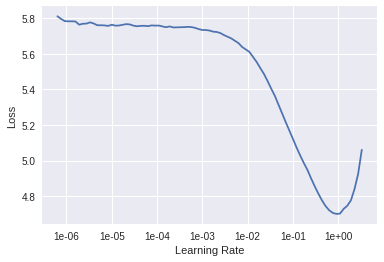

In [53]:
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(3, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.005811,3.484247,0.348140,00:03
1,4.052349,3.017199,0.407441,00:03
2,3.530997,2.980220,0.407813,00:03


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze()

In [58]:
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.625372,2.865228,0.431250,00:03
1,2.500508,2.835214,0.434524,00:03


In [0]:
learn.save('fine_tuned')

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = ""
N_WORDS = 20
N_SENTENCES = 2

In [62]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

 Press Release : company Corporation Announces Date for Earnings Release and Conference
 company Energy to boost production output and stop blast at Iran 's gas field ; This part


In [0]:
learn.save_encoder('fine_tuned_enc')

**Classifier**

In [0]:
# Classifier
data_clas = TextClasDataBunch.from_df(path = ".", train_df = train_data, valid_df = test_data, vocab = data_lm.vocab, text_cols="text", label_cols="label")

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [90]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


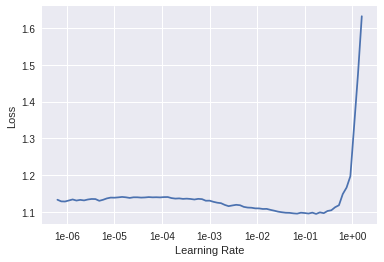

In [91]:
learn.recorder.plot()

In [92]:
learn.fit_one_cycle(1, 5e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.078570,0.996844,0.543568,00:02


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [101]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(2e-3/(2.6**4),2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.022598,0.971229,0.539419,00:02


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [104]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.989325,0.954266,0.572614,00:04


In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [115]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.977477,0.959264,0.556017,00:05
1,0.948694,0.959307,0.543568,00:05


In [116]:
learn.predict("Revenues went up")

(Category Bad, tensor(0), tensor([0.4653, 0.3655, 0.1692]))

In [0]:
preds,y = learn.get_preds(ds_type="test", ordered = True)

In [118]:
accuracy(preds,y)

tensor(0.6590)

In [0]:
individual_preds = test_data['text'].apply(learn.predict)

In [121]:
i = 1
print(test_data['text'][i])
print(learn.predict(test_data['text'][i]))
print(individual_preds[i])
print(preds[i])

company Plans More Asset Sales, Debt Reduction
(Category Good, tensor(1), tensor([0.1279, 0.7119, 0.1603]))
(Category Good, tensor(1), tensor([0.1279, 0.7119, 0.1603]))
tensor([0.0437, 0.1880, 0.7683])


In [122]:
test_data.label[0:10]

0       Good
1       Good
2       Good
3       Good
4       Good
5       Good
6        Bad
7    Neutral
8        Bad
9       Good
Name: label, dtype: object

In [123]:
y[0:10]

tensor([0, 2, 0, 1, 0, 0, 0, 0, 2, 2])

In [0]:
bad_pred = []
good_pred = []
neutral_pred = []

for idx in range(test_data.shape[0]):
  bad_pred.append(np.array(individual_preds[idx][2][0]).item())
  good_pred.append(np.array(individual_preds[idx][2][1]).item())
  neutral_pred.append(np.array(individual_preds[idx][2][2]).item())



In [0]:
test_data['bad'] = bad_pred
test_data['good'] = good_pred
test_data['neutral'] = neutral_pred

In [0]:
from google.colab import files

test_data.to_csv('scored_test_data_company.csv')
files.download('scored_test_data_company.csv')